## Modules import

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib widget 
import pandas as pd 
import config 
import matplotlib as mpl
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import glob
from datetime import datetime
import scipy
import xarray as xr

TANK_VOLUME = 42 #in liter 
EXP_DURATION_MIN = 10

cmap = plt.cm.plasma(np.linspace(0, 1, 8)) # colormap for the speeds
norm = mpl.colors.Normalize(vmin=0, vmax=7)

## Get metadata of experiments from the xslx file 

In [3]:
metadata_file = '../raw_data/raw_data_camille/sand_smelt_camille_metadata.xlsx'

## Load and rename the columns 
metadata = pd.read_excel(metadata_file, 
                         names=['nfish', 'rep', 'start_time', 'end_time', 'max_speed', 'duration', 'last_exp_duration_min'])

## change time format
metadata['start_time'] = pd.to_datetime(metadata['start_time'], format='%H:%M:%S').dt.time
metadata['end_time']   = pd.to_datetime(metadata['end_time'],   format='%H:%M:%S').dt.time

metadata

,nfish,rep,start_time,end_time,max_speed,duration,last_exp_duration_min
0,1,1,13:34:00,14:31:00,6,00:57:00,7.0
1,1,2,10:41:00,11:20:00,4,00:39:00,9.0
2,1,3,12:22:00,12:41:00,2,00:19:00,9.0
3,1,4,15:03:00,15:39:00,4,00:36:00,6.0
4,1,5,08:47:00,09:45:00,5,00:58:00,18.0
5,1,6,10:42:00,11:30:00,5,00:48:00,8.0
6,2,1,09:53:00,11:00:00,6,01:07:00,17.0
7,2,2,14:11:00,15:11:00,6,01:00:00,10.0
8,2,3,13:36:00,14:13:00,4,00:37:00,7.0
9,2,4,08:42:00,09:25:00,4,00:43:00,13.0


## Function to extract metabolic rates for a set of speeds

In [4]:
def extract_rates(df, nspeeds: int, plot: bool=False) -> tuple:
    """extract metabolic rates from a complete experiments with different speeds. It computes a linear regression on the O2 consumed, on each timeseries segment corresponding to each speed. The speed must be ordered and start at 1 BL/s, by steps of 1 BL/s. The data provided must start at t=0s, meaning at the begining of the the first speed tested 

    Args:
        df (pandas Dataframe): a dataframe extracted from raw datafile that contains all time points of an acquisition
        nspeeds (int): number of speed in the experiments 
        plot (bool, optional): boolean for plotting function: if True, plots the timeseries of the O2 measurement and the computed O2 rates (slopes of the linear regression) corresponding to each speed. Defaults to False.

    Returns:
        tuple: two numpy arrays of size (nspeeds,), that contains: 
        - the metabolic rate for each speed, in mg/h 
        - the standard error made on the linear regression used to compute the O2 rate
    """


    speeds = np.arange(1, nspeeds+1)

    if plot:
        _, axs = plt.subplots(1, 2, figsize=(7, 3))
        ax = axs[0]
        ax.plot(df['time (s)'] / 60, df['O2 consumption (mg)'], 'k.', ms=4)
        ax.set_xlabel('Time (min)'); ax.set_ylabel('O2 consumption (mg)');
    
    O2_rates, O2_rates_std_err = np.array([]), np.array([])

    print('Extracting rates:')  
    for i, speed in enumerate(speeds):

        t_ini_seconds = i       * EXP_DURATION_MIN * 60
        t_fin_seconds = (i + 1) * EXP_DURATION_MIN * 60

        # slice the dataset for time corresponding to one speed 
        df_ = df[(df['time (s)'] >= t_ini_seconds) &
                 (df['time (s)'] < t_fin_seconds)]
        
        print(f'\t{t_ini_seconds/60} min - {t_fin_seconds/60} min  | speed = {speed} BL/s\n\t\t- Datapoints: {len(df_)}')

        # linear regression to get the rate of O2 consumed per unit time
        O2_rate, intercept, _, _, std_err = scipy.stats.linregress(df_['time (s)'], 
                                                                   df_['O2 consumption (mg)'])
        
        print(f'\t\t- Metabolic rate: {O2_rate * 3600:.1f} mg of O2/h\n')
        
        ## add the extracted rates into the general array 
        O2_rates = np.r_[O2_rates, O2_rate]; O2_rates_std_err = np.r_[O2_rates_std_err, std_err]

        ## plot functions 
        if plot: 
            ax = axs[0]
            ax.plot(df_['time (s)'] / 60, df_['O2 consumption (mg)'], 'o', color=cmap[speed], zorder=0, alpha=1)
            ax.plot(df_['time (s)'] / 60, O2_rate * df_['time (s)'] + intercept, 'w-')  
            ax.axvspan(t_ini_seconds/60, t_fin_seconds/60, color=cmap[speed], alpha=0.4, ec='None')
            

            cax = make_axes_locatable(ax).append_axes("right", size="5%", pad="2%")
                    
            cbar = mpl.colorbar.ColorbarBase(cax, 
                                         cmap='plasma',
                                         norm=norm,
                                         orientation='vertical')
            
            cbar.set_label('Speed (BL/s)')

    if plot:     
        ax = axs[1]
        ax.errorbar(speeds, O2_rates * 3600, yerr=O2_rates_std_err * 3600, fmt='ko', mfc='w')

        ax.set_xlabel('Speed (BL/s)')
        ax.set_ylabel('Metabolic rate (mg/h)')

        ax.set_xticks(speeds)

    return O2_rates, O2_rates_std_err


## Function to open a file, load it into a dataframe and clean it 

In [5]:
def load_and_clean_dataframe(filename: str, nspeeds: int, plot: bool=False, start_time_min=None, clock_start=None):
    """load respirometry data into a dataframe pandas. Slice it to keep only the relevent times. 

    Args:
        filename (str): a path to the txt file corresponding to a data acquisition of respirometry
        nspeeds (int): number of speeds tested in the experiment. The speeds must be ordered and start at 1 BL/s, by steps of 1 BL/s.
        plot (bool, optional): boolean for plotting function: if True, plots the timeseries of the O2 measurement. Defaults to False.
        start_time_min (int, optional): number of minutes to remove before the start of the experiment in the file. Keep clock-start to None if provided. Defaults to None.
        clock_start (datetime, optional): a time at which the first experiment started (given in the metadata file). Defaults to None.

    Returns:
        df (pandas dataframe): a dataframe of the O2 measurement timeseries, with 3 columns:
        - time in seconds 
        - O2 consumption in mg 
    """
    
    ## Load the data file
    df = pd.read_csv(filename, 
                    skiprows=25, 
                    encoding='cp1252', 
                    delimiter='\t', 
                    usecols=[1, 2, 3], 
                    names=['clock', 'time (s)', 'O2 concentration (mg/L)'],
                    )

    ## use the provided starting time of the experiments (in the metadata file) to find the timedelta (in min)
    df['clock'] = pd.to_datetime(df['clock'], format='%H:%M:%S.%f').dt.time
    
    if clock_start: 
        start_time_min = int(df[df['clock'] > clock_start].iloc[0]['time (s)'] / 60) + 1

    print(f'Slicing the dataframe : from {start_time_min} min to {(start_time_min  + EXP_DURATION_MIN * (nspeeds))} min -- {nspeeds} speeds = {nspeeds * EXP_DURATION_MIN} min\n')

    ## Select the beginning of the experiment and slice the dataset to keep only relevant times
    df = df[(df['time (s)'] >= start_time_min * 60) &
            (df['time (s)'] < (start_time_min  + EXP_DURATION_MIN * (nspeeds)) * 60)].reset_index(drop=True)

    # reset time to have t_0 = 0s 
    df['time (s)'] = np.round(df['time (s)'] - df['time (s)'].min())

    # convert oxygen concentration (mg/L) into absolute oxygen consumption (mg)
    df['O2 consumption (mg)'] = (df['O2 concentration (mg/L)'].iloc[0] - df['O2 concentration (mg/L)']) * TANK_VOLUME

    df = df.drop(labels=['O2 concentration (mg/L)', 'clock'], axis=1)

    if plot:
        ## plot BG data 
        fig, ax = plt.subplots() 
        ax.plot(df['time (s)'] / 60, df['O2 consumption (mg)'], '.')
        ax.set_xlabel('Time (min)') 
        ax.set_ylabel('O2 consumption (mg)')
        ax.set_title('Metabolic rate data')

    return df

## Function to create a Dataframe from the extracted O2 rates

In [6]:
def rates2df(O2_rates, O2_rates_std_err, nspeeds, nfish):
    
    speeds = np.arange(1, nspeeds+1)

    df = pd.DataFrame({
        'speed (BL/s)': speeds,
        'metabolic rate (mg of O2/h)': O2_rates * 3600,
        'metabolic rate std error (mg of O2/h)': O2_rates_std_err * 3600,
        'nfish': np.ones_like(speeds) * nfish,
    })

    return df

## Extract *background* metabolic rate 

### BG data extraction & computing BG metabolic rate for each speed

The experiment on BG metabolic rate is the following : no fish  in the tank, 7 speeds from 1 to 7 BL/s 

Slicing the dataframe : from 12 min to 82 min -- 7 speeds = 70 min

Extracting rates:
	0.0 min - 10.0 min  | speed = 1 BL/s
		- Datapoints: 10
		- Metabolic rate: 4.6 mg of O2/h

	10.0 min - 20.0 min  | speed = 2 BL/s
		- Datapoints: 10
		- Metabolic rate: 3.5 mg of O2/h

	20.0 min - 30.0 min  | speed = 3 BL/s
		- Datapoints: 10
		- Metabolic rate: 3.7 mg of O2/h

	30.0 min - 40.0 min  | speed = 4 BL/s
		- Datapoints: 10
		- Metabolic rate: 2.6 mg of O2/h

	40.0 min - 50.0 min  | speed = 5 BL/s
		- Datapoints: 10
		- Metabolic rate: 1.7 mg of O2/h

	50.0 min - 60.0 min  | speed = 6 BL/s
		- Datapoints: 10
		- Metabolic rate: 3.0 mg of O2/h

	60.0 min - 70.0 min  | speed = 7 BL/s
		- Datapoints: 10
		- Metabolic rate: 3.8 mg of O2/h



,speed (BL/s),metabolic rate (mg of O2/h),metabolic rate std error (mg of O2/h),nfish
0,1,4.627636,0.761648,0
1,2,3.451636,1.138971,0
2,3,3.696000,0.579760,0
3,4,2.565818,0.519722,0
4,5,1.725818,0.342702,0
5,6,3.008727,0.869071,0
6,7,3.757091,0.790944,0


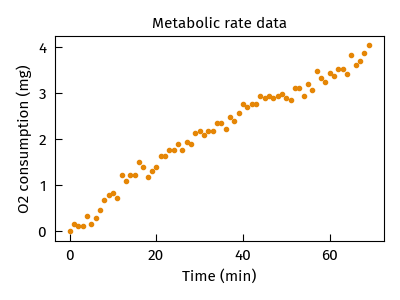

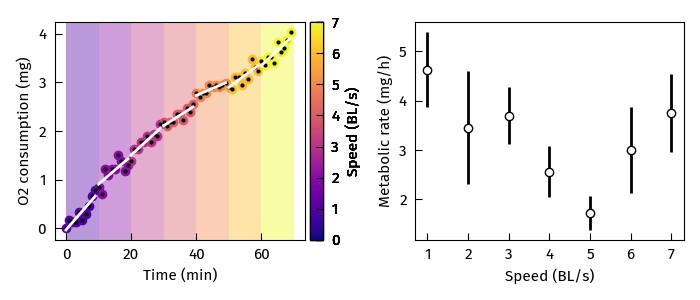

In [8]:
## Chose one data file for the BG metabolic rate 
filebg = '../raw_data/raw_data_camille/background/2023-05-25_141719_bap_background1_25may2023/ChannelData/A_Firesting O2 (4 Channels)_(A Ch.1)_Oxygen.txt'

bg_dataframe = load_and_clean_dataframe(filebg, nspeeds=7, start_time_min=12, plot=True)

O2_rates, O2_rates_std_err = extract_rates(bg_dataframe, nspeeds=7, plot=True); 
bg_df_rates = rates2df(O2_rates, O2_rates_std_err, nspeeds=7, nfish=0)

bg_df_rates

## Computing metabolic rate for every experiment 


## Loading experiment : 5 fish
Slicing the dataframe : from 30 min to 80 min -- 5 speeds = 50 min

Extracting rates:
	0.0 min - 10.0 min  | speed = 1 BL/s
		- Datapoints: 10
		- Metabolic rate: 9.9 mg of O2/h

	10.0 min - 20.0 min  | speed = 2 BL/s
		- Datapoints: 10
		- Metabolic rate: 5.6 mg of O2/h

	20.0 min - 30.0 min  | speed = 3 BL/s
		- Datapoints: 10
		- Metabolic rate: 3.6 mg of O2/h

	30.0 min - 40.0 min  | speed = 4 BL/s
		- Datapoints: 10
		- Metabolic rate: 3.9 mg of O2/h

	40.0 min - 50.0 min  | speed = 5 BL/s
		- Datapoints: 7
		- Metabolic rate: 4.0 mg of O2/h


## Loading experiment : 5 fish
Slicing the dataframe : from 23 min to 83 min -- 6 speeds = 60 min

Extracting rates:
	0.0 min - 10.0 min  | speed = 1 BL/s
		- Datapoints: 10
		- Metabolic rate: 7.8 mg of O2/h

	10.0 min - 20.0 min  | speed = 2 BL/s
		- Datapoints: 10
		- Metabolic rate: 3.9 mg of O2/h

	20.0 min - 30.0 min  | speed = 3 BL/s
		- Datapoints: 10
		- Metabolic rate: 5.2 mg of O2/h

	30.0 min - 40.

/var/folders/6g/_pvh03v53030m1dmqwzw8b0r0000gn/T/ipykernel_2097/181952163.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axs = plt.subplots(1, 2, figsize=(7, 3))


	50.0 min - 60.0 min  | speed = 6 BL/s
		- Datapoints: 7
		- Metabolic rate: 4.0 mg of O2/h


## Loading experiment : 2 fish
Slicing the dataframe : from 23 min to 83 min -- 6 speeds = 60 min

Extracting rates:
	0.0 min - 10.0 min  | speed = 1 BL/s
		- Datapoints: 10
		- Metabolic rate: 3.4 mg of O2/h

	10.0 min - 20.0 min  | speed = 2 BL/s
		- Datapoints: 10
		- Metabolic rate: 2.2 mg of O2/h

	20.0 min - 30.0 min  | speed = 3 BL/s
		- Datapoints: 10
		- Metabolic rate: 3.9 mg of O2/h

	30.0 min - 40.0 min  | speed = 4 BL/s
		- Datapoints: 10
		- Metabolic rate: 1.3 mg of O2/h

	40.0 min - 50.0 min  | speed = 5 BL/s
		- Datapoints: 10
		- Metabolic rate: 2.4 mg of O2/h

	50.0 min - 60.0 min  | speed = 6 BL/s
		- Datapoints: 10
		- Metabolic rate: 1.7 mg of O2/h


## Loading experiment : 2 fish
Slicing the dataframe : from 27 min to 67 min -- 4 speeds = 40 min

Extracting rates:
	0.0 min - 10.0 min  | speed = 1 BL/s
		- Datapoints: 10
		- Metabolic rate: 5.9 mg of O2/h

	10.0 min - 20.

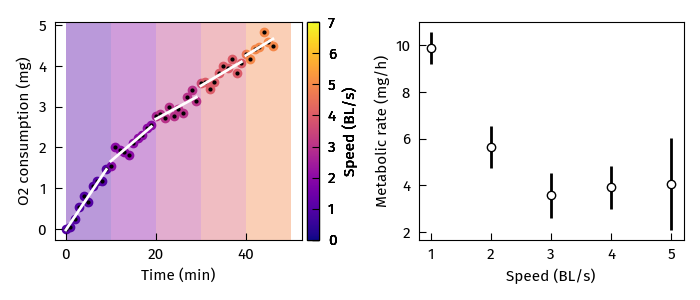

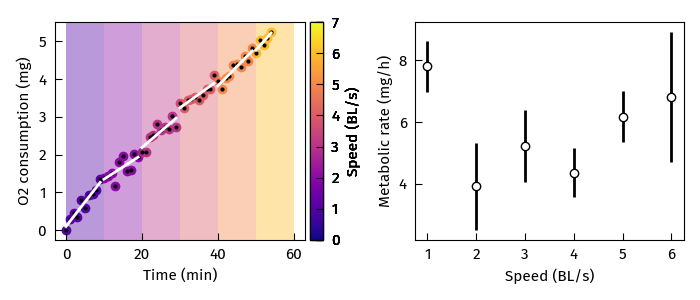

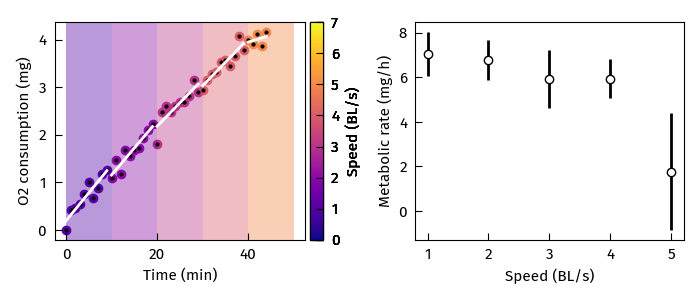

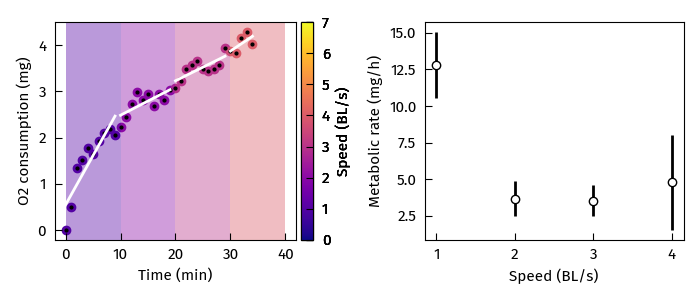

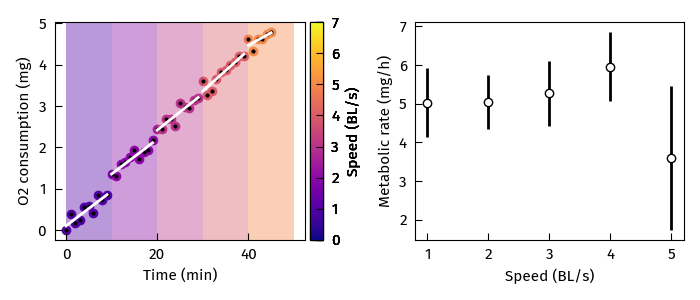

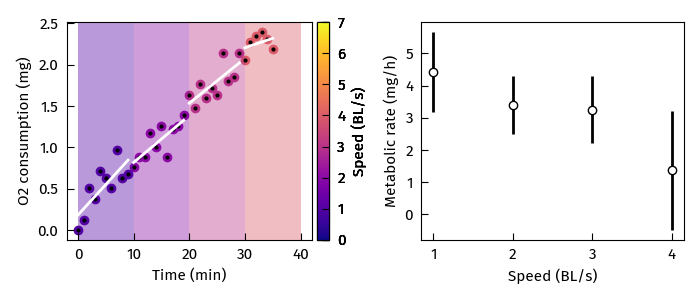

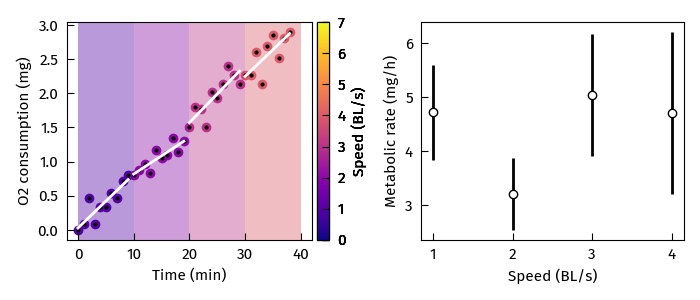

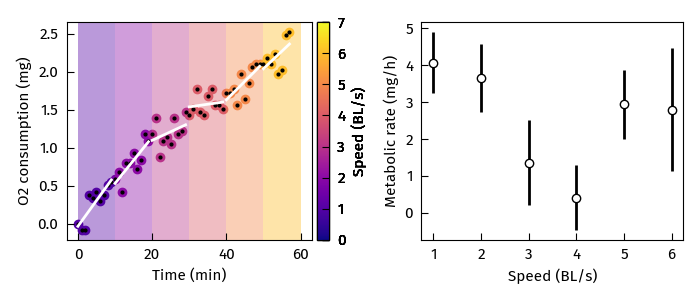

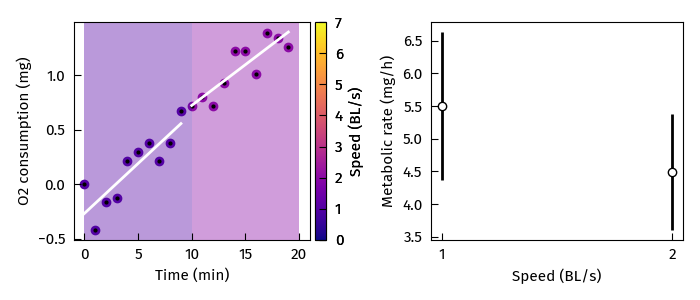

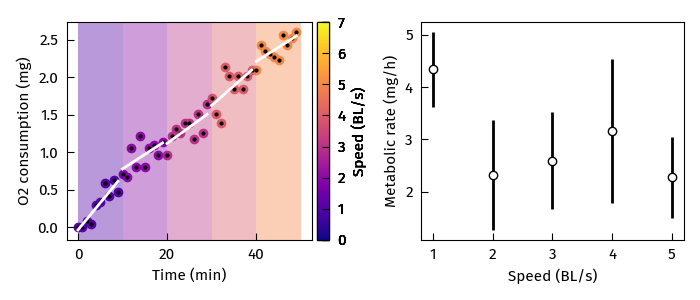

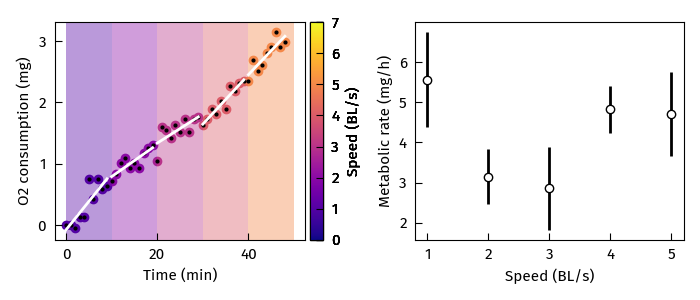

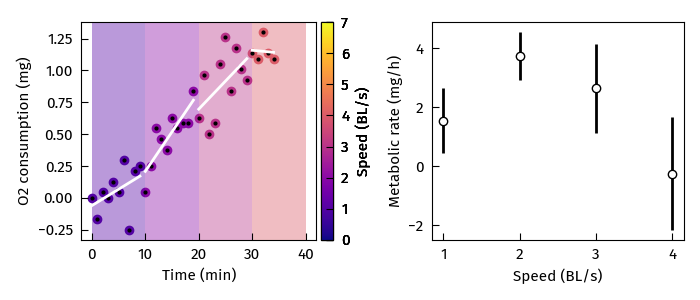

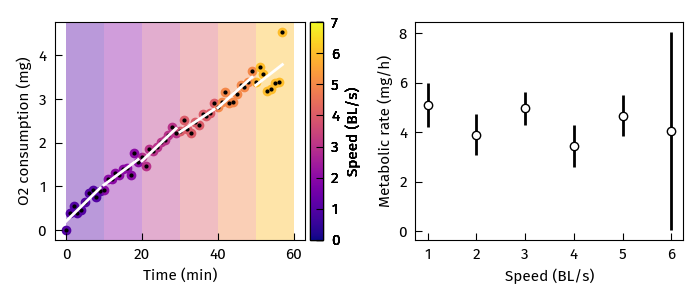

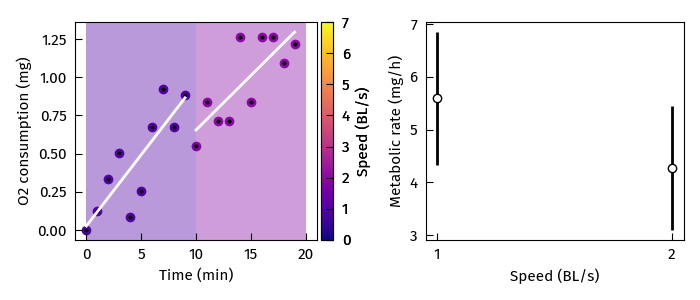

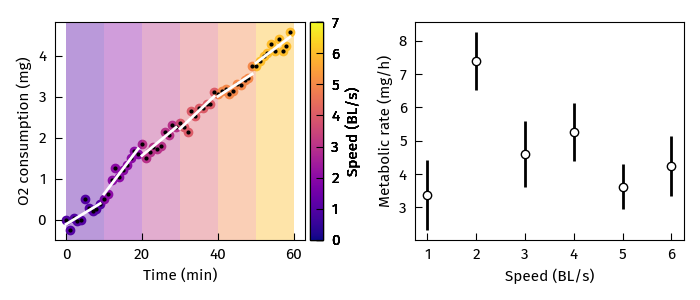

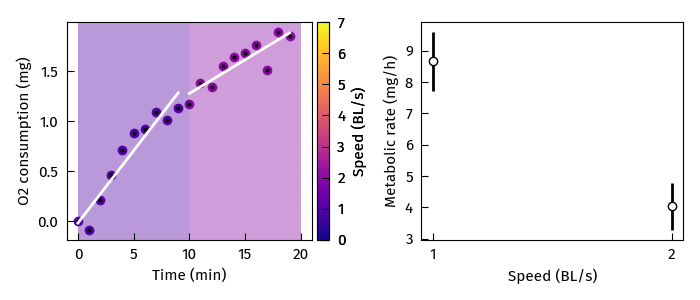

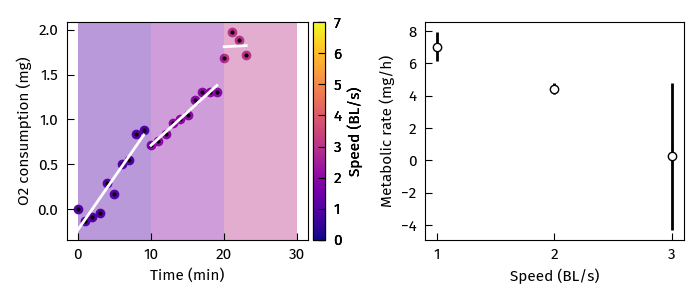

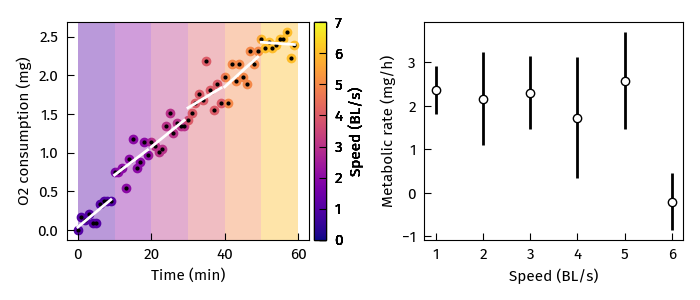

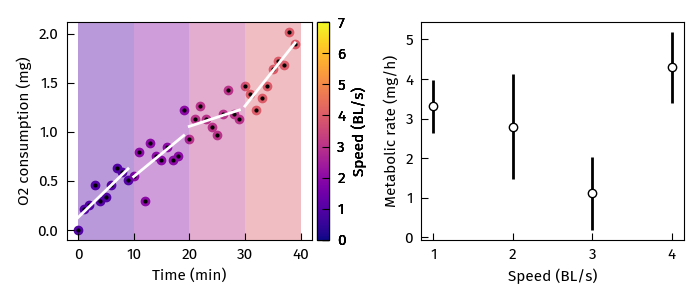

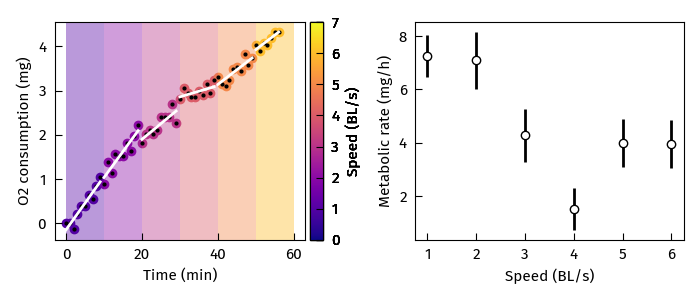

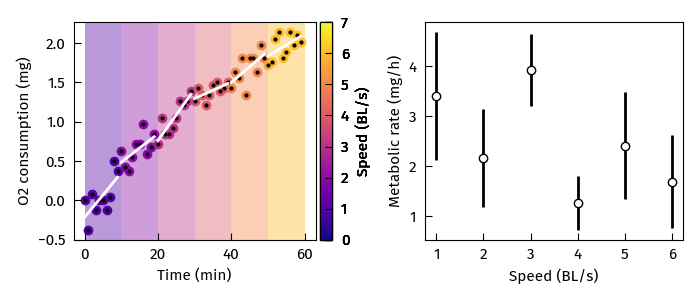

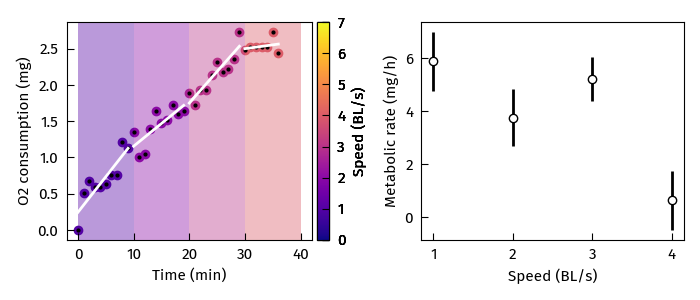

In [10]:

## Get all data files 
files = glob.glob(f'../raw_data/raw_data_camille/*_ind/*/ChannelData/*Ch.1*')

## an array to store the created df for each experiment 
all_dataframes = []
for file in files: 
    nfish = int(file.split('_ind')[0][-1]) 
    rep = int(file.split('rep')[1][0]) 
    
    _, _, clock_start, _, maxspeed, _, _ = metadata[(metadata.nfish==nfish) & (metadata.rep==rep)].values[0]

    print(f'\n## Loading experiment : {nfish} fish')

    df = load_and_clean_dataframe(file, nspeeds=maxspeed, plot=False, start_time_min=None, clock_start=clock_start)

    O2_rates, O2_rates_std_err = extract_rates(df, nspeeds=maxspeed, plot=True); 

    df = rates2df(O2_rates, O2_rates_std_err, nspeeds=maxspeed, nfish=nfish)

    all_dataframes.append(df)
    

## Substract the BG data to the main data 

In [11]:
global_df = pd.concat([bg_df_rates] + all_dataframes)
global_df = global_df.reset_index(drop=True)

global_df = global_df.set_index(['speed (BL/s)', 'nfish'], append=False)

## extract the date for BG metabolic rate and error on BG metabolic rate and cast it into a dataframe with the right size to substract it to all the data
background_metabolic_rate           = global_df.xs(0, level='nfish').reindex(global_df.index, level='speed (BL/s)')['metabolic rate (mg of O2/h)']
error_on_background_metabolic_rate  = global_df.xs(0, level='nfish').reindex(global_df.index, level='speed (BL/s)')['metabolic rate std error (mg of O2/h)']

## [O2] = [O2] - [BG O2] and [error on O2] = [error on O2] + [error on BG O2]
global_df['metabolic rate (mg of O2/h)'] = global_df['metabolic rate (mg of O2/h)'] - background_metabolic_rate
global_df['metabolic rate std error (mg of O2/h)'] = global_df['metabolic rate std error (mg of O2/h)'] + error_on_background_metabolic_rate


global_df = global_df.reset_index() 
print(global_df.head())

global_df = global_df[global_df['nfish']!=0]

   speed (BL/s)  nfish  metabolic rate (mg of O2/h)  \
0             1      0                          0.0   
1             2      0                          0.0   
2             3      0                          0.0   
3             4      0                          0.0   
4             5      0                          0.0   

   metabolic rate std error (mg of O2/h)  
0                               1.523297  
1                               2.277941  
2                               1.159521  
3                               1.039443  
4                               0.685404  


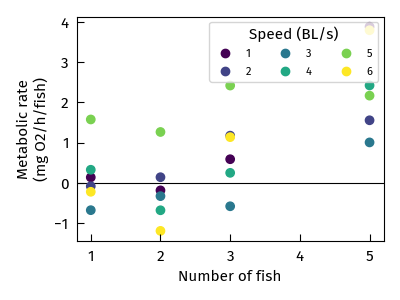

In [12]:
fig, ax = plt.subplots() 

grp = global_df.groupby(['speed (BL/s)', 'nfish'], as_index=False).mean() 

grp = grp[grp['nfish']!=0]

scatter = ax.scatter(grp['nfish'], 
                     grp['metabolic rate (mg of O2/h)'], 
                     c=grp['speed (BL/s)'])


ax.axhline(0, ls='-', color='k', lw=0.8, zorder=0)

legend1 = ax.legend(*scatter.legend_elements(), 
                    loc="upper right", 
                    title="Speed (BL/s)",
                    frameon=True, ncol=3)


ax.set_xlabel('Number of fish')
ax.set_ylabel('Metabolic rate\n(mg O2/h/fish)');


In [14]:
global_df.to_csv('../cleaned_data/condensed_dataframes/data_exp-camille_jun23.csv')